# <font color="green">  1. Imports  </font>

In [169]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from faker import Faker
from elasticsearch import Elasticsearch
from sklearn.feature_extraction.text import TfidfVectorizer


# <font color="blue">  2. Data  </font>

In [170]:
df = pd.read_csv('data/Emotion_final_bronze.csv')

# <font color="red">  3. Analyse </font>

In [171]:
df

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
21454,Melissa stared at her friend in dism,fear
21455,Successive state elections have seen the gover...,fear
21456,Vincent was irritated but not dismay,fear
21457,Kendall-Hume turned back to face the dismayed ...,fear


In [172]:
df.Emotion.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'happy'],
      dtype=object)

In [173]:
counts = df['Emotion'].value_counts()
print(counts)

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64


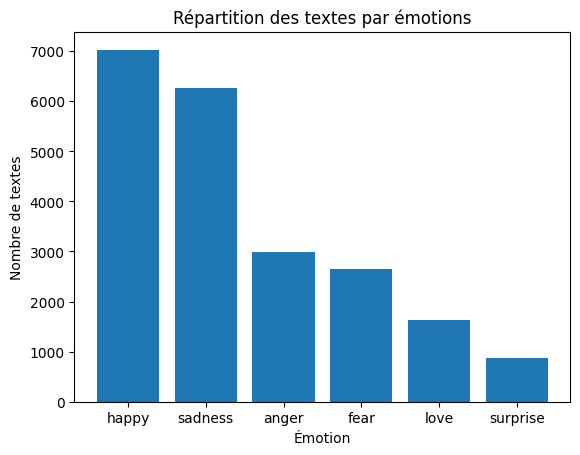

In [174]:
counts = df['Emotion'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel('Émotion')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes par émotions')
plt.show()


# <font color="red">  4. Stopwords  </font>

In [175]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
len(stopwords)

326

In [176]:


nlp = spacy.load("en_core_web_sm")

# Obtention des anciens stopwords
old_stopwords = nlp.Defaults.stop_words

# Création des nouveaux stopwords en supprimant les apostrophes
new_stopwords = {word.replace("'", "") for word in old_stopwords}

# autre
autre = {',', 't', 'feel', 'feeling', '`', 'little', 'bit'}
# Union des anciens et nouveaux stopwords
all_stopwords = old_stopwords.union(new_stopwords, autre)

print(all_stopwords)


{'never', 'see', 'nobody', 'your', "'re", 'among', 'formerly', 'whatever', 'unless', 'being', 'could', 'forty', 'each', 'upon', 'everywhere', 'without', 'is', 'were', 'feel', 'under', 'first', 'nine', 'whither', 'cannot', 't', 'whose', 'beforehand', 'still', 'or', 'he', 'thereby', 'two', 'latter', 'least', 'last', '‘d', 'often', 'with', 'anyhow', '’d', 'had', 'whole', 'us', 'everyone', 'go', 'since', 'back', 'hereby', 'myself', 'yourselves', 'ten', 'and', 'less', 'fifteen', 'by', 'even', 'except', 'someone', 'n‘t', 'hundred', 'was', 'made', 'not', 'though', 'five', 'amongst', 'fifty', '‘s', 'per', 'every', 'whence', 'toward', 'it', 'these', 'from', 'you', 'across', 'nor', 'few', 'feeling', 'some', 'say', 'about', 'll', 'how', 'hereafter', 'more', 'former', '’re', 'others', 'where', 'nt', 'much', 'itself', 'keep', 'three', 'other', 'various', 'front', 'regarding', 'their', 'we', 'only', 'our', 'very', 'again', 'serious', 'her', '’ll', 'them', 'around', 'sixty', "n't", 'thereupon', 'ther

# <font color="green">  5. Mots & sentiments  </font>

In [177]:
sentiment_groups = df.groupby('Emotion')

In [178]:
word_counts = {}

for sentiment, group in sentiment_groups:
    sentiment_words = []
    
    for text in group['Text']:
        doc = nlp(text)
        sentiment_words.extend([token.text.lower() for token in doc if token.text.lower() not in all_stopwords])
        
    word_counts[sentiment] = sentiment_words


In [179]:
from collections import Counter

top_n = 30

top_words_per_sentiment = {}

for sentiment, words in word_counts.items():
    word_counter = Counter(words)
    top_words = [word for word, count in word_counter.most_common(top_n)]
    top_words_per_sentiment[sentiment] = top_words


In [180]:
top_words_per_sentiment

{'anger': ['like',
  'people',
  'know',
  'time',
  'want',
  'angry',
  'think',
  'things',
  'way',
  'don',
  'offended',
  'resentful',
  'cold',
  'irritable',
  'going',
  'bothered',
  'greedy',
  'life',
  'mad',
  'insulted',
  'irritated',
  'need',
  'pissed',
  'violent',
  'annoyed',
  'hated',
  'dissatisfied',
  'fucked',
  'rude',
  'right'],
 'fear': ['like',
  'know',
  'anxious',
  'time',
  'people',
  'nervous',
  'want',
  'strange',
  'terrified',
  'think',
  'going',
  'afraid',
  'agitated',
  'scared',
  'frightened',
  'weird',
  'things',
  'unsure',
  'vulnerable',
  'apprehensive',
  'uncertain',
  'overwhelmed',
  'way',
  'shaken',
  'pressured',
  'day',
  'hesitant',
  'reluctant',
  'paranoid',
  'intimidated'],
 'happy': ['like',
  'time',
  'know',
  'people',
  'want',
  'good',
  'think',
  'pretty',
  'life',
  'love',
  'going',
  'happy',
  'day',
  'things',
  'way',
  'need',
  'work',
  'right',
  'today',
  'don',
  'excited',
  'sure',


 # <font color="green">  5. Corrélations Sentiments  </font>

In [181]:
sentiment_labels = list(top_words_per_sentiment.keys())

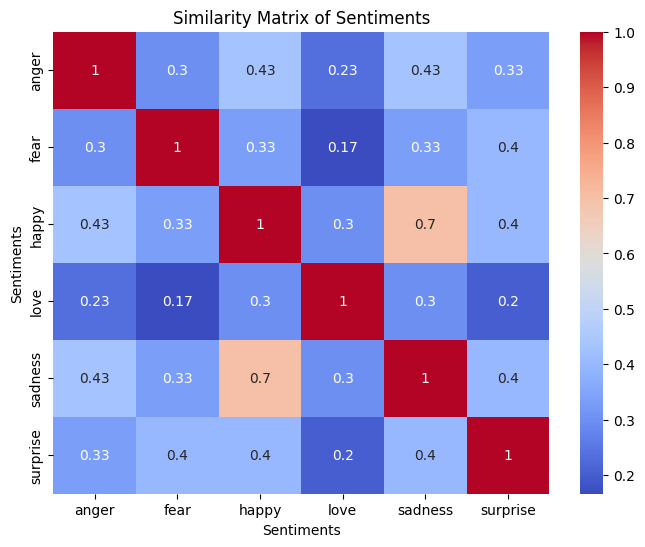

In [182]:

num_sentiments = len(top_words_per_sentiment)
similarity_matrix = np.zeros((num_sentiments, num_sentiments))

# Création d'un corpus de textes pour chaque sentiment
corpus = [' '.join(top_words_per_sentiment[sentiment]) for sentiment in sentiment_labels]

# Création d'un vectoriseur pour compter les fréquences des mots
vectorizer = CountVectorizer()

# Transformation du corpus en une matrice de fréquences des mots
X = vectorizer.fit_transform(corpus)

# Calcul de la similarité cosinus entre chaque paire de sentiments
similarity_matrix = cosine_similarity(X)

# Affichage de la matrice de similarité sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, xticklabels=sentiment_labels, yticklabels=sentiment_labels, cmap='coolwarm')
plt.xlabel('Sentiments')
plt.ylabel('Sentiments')
plt.title('Similarity Matrix of Sentiments')
plt.show()


  # <font color="green">  6. Bag of Words & TF-IDF  </font>

In [183]:
# Fonction de prétraitement
def preprocess_text(text):
    # Prétraitement avec Spacy
    doc = nlp(text)
    
    tokens = []
    for token in doc:
        # Ignorer la ponctuation et les espaces
        if not token.is_punct and not token.is_space:
            # Lemmatisation
            lemma = token.lemma_
            tokens.append(lemma)
    
    # Retourner le texte prétraité sous forme d'une chaîne de caractères
    return ' '.join(tokens)

# Prétraitement du DataFrame
df['preprocessed_text'] = df['Text'].apply(preprocess_text)

# Liste des stopwords
stopwords_list = list(old_stopwords) + list(new_stopwords) + list(autre)

# Création de la représentation Bag of Words
vectorizer = CountVectorizer(stop_words = stopwords_list)
bow_representation = vectorizer.fit_transform(df['preprocessed_text'].to_list())

# Création de la représentation TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords_list)
tfidf_representation = tfidf_vectorizer.fit_transform(df['preprocessed_text'].to_list())

# Exemple d'utilisation de la représentation Bag of Words
print(bow_representation.toarray())

# Exemple d'utilisation de la représentation TF-IDF
print(tfidf_representation.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [184]:
#len(old_stopwords)+len(new_stopwords)+len(autre)


In [185]:
#len(stopwords_list)

In [186]:
#vectorizer

In [187]:
#bow_representation

In [188]:
def count_zeros(matrix):
    count = 0
    for row in matrix:
        for element in row:
            if element == 0:
                count += 1
    return count


In [189]:
#count_zeros(bow_representation.toarray())


In [190]:
#count_zeros(tfidf_representation.toarray())

# <font color="blue"> 7. Modèle </font>   

In [191]:
# Division des données en entraînement et en test
X_train, X_test, y_train, y_test = train_test_split(tfidf_representation, df['Emotion'], test_size=0.2, random_state=42)

In [192]:
# Exemple d'utilisation d'un modèle de classification (SVM)
svm_model = SVC(probability=True)
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8427306616961789


In [193]:
# Exemple de prédiction d'une nouvelle phrase
new_phrase = "This movie is great!"
preprocessed_new_phrase = preprocess_text(new_phrase)
tfidf_representation_new_phrase = tfidf_vectorizer.transform([preprocessed_new_phrase])
prediction = svm_model.predict(tfidf_representation_new_phrase)

print("Phrase:", new_phrase)
print("Emotion prédite:", prediction[0]) 

Phrase: This movie is great!
Emotion prédite: happy


# <font color="blue"> 8. Faker données ELasticsearch utilsant notre modèl</font>   

In [194]:
fake = Faker()
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])
# vectorizer = TfidfVectorizer(stop_words='english')

In [195]:
for _ in range(100):
    # Générer des données Faker
    patient_lastname = fake.last_name()
    patient_firstname = fake.first_name()
    text = fake.text()
    date = fake.date()
    
    # Prétraiter le texte avec le modèle TF-IDF
    preprocessed_text = preprocess_text(text)
    tfidf_representation = tfidf_vectorizer.transform([preprocessed_text])
    
    # Prédire l'émotion et la confidence avec le modèle TF-IDF
    emotion = svm_model.predict(tfidf_representation)[0]
    confidence = svm_model.predict_proba(tfidf_representation)[0].max()
    
    # Construire le document Elasticsearch
    document = {
        'patient_lastname': patient_lastname,
        'patient_firstname': patient_firstname,
        'text': text,
        'date': date,
        'patient_left': fake.boolean(),
        'emotion': emotion,
        'confidence': confidence
    }
    
    # Indexer le document dans Elasticsearch
    es.index(index='notes', body=document)


/tmp/ipykernel_5413/888087167.py:28: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.index(index='notes', body=document)
/tmp/ipykernel_5413/888087167.py:28: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  es.index(index='notes', body=document)


In [196]:
# terminal : curl http://localhost:9200/
#======> pour visualiser l'index 'notes'
# http://localhost:9200/notes
#=======> pour voir les données fake
# http://localhost:9200/notes/_search